In [ ]:
!pip install -q flax optax

In [4]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score

import flax.linen as nn
import jax
import jax.numpy as jnp
from flax.training import train_state
import optax
from tqdm import tqdm
import csv

In [5]:
import pandas as pd
import os

DATASET_PATH = "/kaggle/input/140k-real-and-fake-faces"
BASE_IMAGE_PATH = f"{DATASET_PATH}/real_vs_fake/real-vs-fake"

# Load CSVs
train_df = pd.read_csv(os.path.join(DATASET_PATH, "train.csv"))
val_df = pd.read_csv(os.path.join(DATASET_PATH, "valid.csv"))

# ensures labels are integers
train_df['label'] = train_df['label'].astype(int)
val_df['label'] = val_df['label'].astype(int)

# Confirm distribution
print("Train label counts:")
print(train_df['label'].value_counts())

min_class_count = min(train_df['label'].value_counts()[0], train_df['label'].value_counts()[1])
print(f"Using {min_class_count} samples per class")

# Sample 500 real + 500 fake
real_subset = train_df[train_df["label"] == 0].sample(n=min_class_count, random_state=42)
fake_subset = train_df[train_df["label"] == 1].sample(n=min_class_count, random_state=42)

# Combine & shuffle
train_df_small = pd.concat([real_subset, fake_subset]).sample(frac=1, random_state=42).reset_index(drop=True)
print(train_df_small['label'].value_counts())

Train label counts:
label
1    50000
0    50000
Name: count, dtype: int64
Using 50000 samples per class
label
1    50000
0    50000
Name: count, dtype: int64


In [6]:
print("Original training data class distribution:")
print(train_df['label'].value_counts())

Original training data class distribution:
label
1    50000
0    50000
Name: count, dtype: int64


In [7]:
# Selected 500 real and 500 fake images for training
real_subset = train_df[train_df["label"] == 0].sample(n=500, random_state=42)
fake_subset = train_df[train_df["label"] == 1].sample(n=500, random_state=42)

# Merging and shuffling the small training set
train_df_small = pd.concat([real_subset, fake_subset]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Sampled training data class distribution:")
print(train_df_small['label'].value_counts())

Sampled training data class distribution:
label
1    500
0    500
Name: count, dtype: int64


In [8]:
BASE_IMAGE_PATH = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake"

In [9]:
def load_dataset_from_df(df, base_image_dir, image_size=(224, 224), batch_size=32):
    def process(file_path, label):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, image_size)
        img = img / 255.0
        return img, label

    # Build full paths for each image
    image_paths = [os.path.join(base_image_dir, rel_path) for rel_path in df["path"]]
    labels = df["label"].values

    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    ds = ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [16]:
def safe_concat(a, b):
    if isinstance(a, tuple) and len(a) == 0:
        return b
    if isinstance(b, tuple) and len(b) == 0:
        return a
    a = a[0] if isinstance(a, tuple) else a
    b = b[0] if isinstance(b, tuple) else b
    return jnp.concatenate([a, b], axis=0)

class GatingFunction(nn.Module):
    num_experts: int
    threshold: float = 0.0

    @nn.compact
    def __call__(self, x, train=True):
        logits = nn.Dense(self.num_experts)(x)
        weights = nn.softmax(logits)
        weights = jnp.where(weights > self.threshold, weights, 0.0)
        weights = weights / (jnp.sum(weights, axis=1, keepdims=True) + 1e-8)

        if not train:
            # jax.debug.print("Gating weights shape: {}", weights.shape)
            self.sow('intermediates', 'gating_weights', weights, reduce_fn=safe_concat)

        return weights


class Expert(nn.Module):
    hidden_dim: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        return x

class ForensicMoEBlock(nn.Module):
    num_experts: int
    expert_hidden_dim: int
    threshold: float = 0.1

    @nn.compact
    def __call__(self, x, train=True):
        gating = GatingFunction(self.num_experts, self.threshold)(x, train=train)
        expert_outputs = [Expert(self.expert_hidden_dim)(x) for _ in range(self.num_experts)]
        expert_stack = jnp.stack(expert_outputs, axis=0)
        gating = gating.T[:, :, None]
        gated_output = jnp.sum(gating * expert_stack, axis=0)
        return gated_output


class VMoEBinaryClassifier(nn.Module):
    num_classes: int = 2

    @nn.compact
    def __call__(self, x, train=True):
        x = x.reshape((x.shape[0], -1))
        for _ in range(2):
            x = ForensicMoEBlock(num_experts=3, expert_hidden_dim=256)(x, train=train)
        x = nn.Dense(64)(x)
        x = nn.relu(x)
        x = nn.Dense(self.num_classes)(x)
        return x

In [26]:
def create_train_state(rng, model, learning_rate, input_shape):
    variables = model.init(rng, jnp.ones(input_shape))
    tx = optax.adam(learning_rate)
    state = train_state.TrainState.create(apply_fn=model.apply, params=variables['params'], tx=tx)
    return state, variables

@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        x, y = batch
        logits = state.apply_fn({'params': params}, x)
        one_hot = jax.nn.one_hot(y, 2)
        loss = optax.softmax_cross_entropy(logits, one_hot).mean()
        return loss

    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss

In [27]:
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

def evaluate(model, state, val_ds):
    y_true, y_pred, y_prob, expert_usage = [], [], [], []

    for batch in val_ds:
        x_batch, y_batch = batch
        x_batch = jnp.array(x_batch).reshape((x_batch.shape[0], -1))
        
        logits, intermediates = model.apply(
            {'params': state.params},
            x_batch,
            mutable=['intermediates'],
            train=False
        )

        # Get gating weights from intermediates
        gating_weights = intermediates.get('intermediates', {}).get('gating_weights', None)

        # Predictions
        probs = jax.nn.softmax(logits, axis=-1)
        preds = jnp.argmax(probs, axis=-1)

        y_true.extend(np.array(y_batch))
        y_pred.extend(np.array(preds))
        y_prob.extend(np.array(probs[:, 1]))

        # SAFELY handle gating_weights
        # if gating_weights is not None and isinstance(gating_weights, jnp.ndarray) and gating_weights.ndim == 2:
        #     expert_usage.extend(np.array(gating_weights))
        # else:
            # print(f"Skipping gating weights with shape: {None if gating_weights is None else gating_weights.shape}")

    # Final Metrics
    print(classification_report(y_true, y_pred))
    print("AUC Score:", roc_auc_score(y_true, y_prob))


    if expert_usage:
        expert_usage = np.array(expert_usage)
        plt.figure(figsize=(8, 4))
        plt.title("Average Gating Weights Across Validation Set")
        plt.bar(range(expert_usage.shape[1]), np.mean(expert_usage, axis=0))
        plt.xlabel("Expert Index")
        plt.ylabel("Average Weight")
        plt.show()
    else:
        print("⚠️ No gating weights to plot.")


In [28]:
train_ds = load_dataset_from_df(train_df_small, BASE_IMAGE_PATH)
val_ds = load_dataset_from_df(val_df, BASE_IMAGE_PATH)

In [29]:
rng = jax.random.PRNGKey(0)
input_shape = (1, 224 * 224 * 3)
model = VMoEBinaryClassifier()
state, variables = create_train_state(rng, model, 1e-4, input_shape)

EPOCHS = 30
loss_history = []  # Store average loss for each epoch

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    epoch_loss = []

    for batch in tqdm(train_ds):
        x_batch, y_batch = batch
        x_batch = jnp.array(x_batch).reshape((x_batch.shape[0], -1))
        y_batch = jnp.array(y_batch)
        state, loss = train_step(state, (x_batch, y_batch))
        epoch_loss.append(loss.item())  # Convert JAX DeviceArray to float

    avg_loss = sum(epoch_loss) / len(epoch_loss)
    print(f"🔹 Avg Training Loss: {avg_loss:.4f}")

    # Save for plotting
    loss_history.append(avg_loss)

    # Run validation
    evaluate(model, state, val_ds)


Epoch 1/30


100%|██████████| 32/32 [00:03<00:00,  8.36it/s]


🔹 Avg Training Loss: 0.9909
              precision    recall  f1-score   support

           0       0.57      0.80      0.67     10000
           1       0.67      0.40      0.50     10000

    accuracy                           0.60     20000
   macro avg       0.62      0.60      0.58     20000
weighted avg       0.62      0.60      0.58     20000

AUC Score: 0.6632760300000001
⚠️ No gating weights to plot.

Epoch 2/30


100%|██████████| 32/32 [00:01<00:00, 25.20it/s]


🔹 Avg Training Loss: 0.7392
              precision    recall  f1-score   support

           0       0.51      0.99      0.67     10000
           1       0.82      0.05      0.09     10000

    accuracy                           0.52     20000
   macro avg       0.66      0.52      0.38     20000
weighted avg       0.66      0.52      0.38     20000

AUC Score: 0.667123655
⚠️ No gating weights to plot.

Epoch 3/30


100%|██████████| 32/32 [00:01<00:00, 26.82it/s]


🔹 Avg Training Loss: 0.7008
              precision    recall  f1-score   support

           0       0.78      0.08      0.15     10000
           1       0.52      0.98      0.67     10000

    accuracy                           0.53     20000
   macro avg       0.65      0.53      0.41     20000
weighted avg       0.65      0.53      0.41     20000

AUC Score: 0.64042178
⚠️ No gating weights to plot.

Epoch 4/30


100%|██████████| 32/32 [00:01<00:00, 25.07it/s]


🔹 Avg Training Loss: 0.6536
              precision    recall  f1-score   support

           0       0.60      0.79      0.68     10000
           1       0.69      0.47      0.56     10000

    accuracy                           0.63     20000
   macro avg       0.64      0.63      0.62     20000
weighted avg       0.64      0.63      0.62     20000

AUC Score: 0.697189415
⚠️ No gating weights to plot.

Epoch 5/30


100%|██████████| 32/32 [00:01<00:00, 25.77it/s]


🔹 Avg Training Loss: 0.6152
              precision    recall  f1-score   support

           0       0.61      0.72      0.66     10000
           1       0.66      0.55      0.60     10000

    accuracy                           0.63     20000
   macro avg       0.64      0.63      0.63     20000
weighted avg       0.64      0.63      0.63     20000

AUC Score: 0.697394375
⚠️ No gating weights to plot.

Epoch 6/30


100%|██████████| 32/32 [00:01<00:00, 24.26it/s]


🔹 Avg Training Loss: 0.6024
              precision    recall  f1-score   support

           0       0.60      0.80      0.69     10000
           1       0.71      0.47      0.56     10000

    accuracy                           0.64     20000
   macro avg       0.65      0.64      0.63     20000
weighted avg       0.65      0.64      0.63     20000

AUC Score: 0.7150591900000001
⚠️ No gating weights to plot.

Epoch 7/30


100%|██████████| 32/32 [00:01<00:00, 26.63it/s]


🔹 Avg Training Loss: 0.5710
              precision    recall  f1-score   support

           0       0.52      0.98      0.68     10000
           1       0.79      0.09      0.15     10000

    accuracy                           0.53     20000
   macro avg       0.65      0.53      0.42     20000
weighted avg       0.65      0.53      0.42     20000

AUC Score: 0.6879287249999999
⚠️ No gating weights to plot.

Epoch 8/30


100%|██████████| 32/32 [00:01<00:00, 25.73it/s]


🔹 Avg Training Loss: 0.6083
              precision    recall  f1-score   support

           0       0.74      0.38      0.50     10000
           1       0.58      0.87      0.70     10000

    accuracy                           0.62     20000
   macro avg       0.66      0.62      0.60     20000
weighted avg       0.66      0.62      0.60     20000

AUC Score: 0.70644139
⚠️ No gating weights to plot.

Epoch 9/30


100%|██████████| 32/32 [00:01<00:00, 24.40it/s]


🔹 Avg Training Loss: 0.5266
              precision    recall  f1-score   support

           0       0.65      0.67      0.66     10000
           1       0.66      0.64      0.65     10000

    accuracy                           0.66     20000
   macro avg       0.66      0.66      0.66     20000
weighted avg       0.66      0.66      0.66     20000

AUC Score: 0.71901675
⚠️ No gating weights to plot.

Epoch 10/30


100%|██████████| 32/32 [00:01<00:00, 24.76it/s]


🔹 Avg Training Loss: 0.5690
              precision    recall  f1-score   support

           0       0.56      0.93      0.70     10000
           1       0.79      0.28      0.41     10000

    accuracy                           0.60     20000
   macro avg       0.68      0.60      0.55     20000
weighted avg       0.68      0.60      0.55     20000

AUC Score: 0.7262572950000001
⚠️ No gating weights to plot.

Epoch 11/30


100%|██████████| 32/32 [00:01<00:00, 24.46it/s]


🔹 Avg Training Loss: 0.5386
              precision    recall  f1-score   support

           0       0.66      0.68      0.67     10000
           1       0.67      0.64      0.66     10000

    accuracy                           0.66     20000
   macro avg       0.66      0.66      0.66     20000
weighted avg       0.66      0.66      0.66     20000

AUC Score: 0.72356669
⚠️ No gating weights to plot.

Epoch 12/30


100%|██████████| 32/32 [00:01<00:00, 22.06it/s]


🔹 Avg Training Loss: 0.5644
              precision    recall  f1-score   support

           0       0.82      0.02      0.04     10000
           1       0.50      1.00      0.67     10000

    accuracy                           0.51     20000
   macro avg       0.66      0.51      0.35     20000
weighted avg       0.66      0.51      0.35     20000

AUC Score: 0.6628544399999999
⚠️ No gating weights to plot.

Epoch 13/30


100%|██████████| 32/32 [00:01<00:00, 23.50it/s]


🔹 Avg Training Loss: 0.6418
              precision    recall  f1-score   support

           0       0.58      0.89      0.70     10000
           1       0.77      0.35      0.48     10000

    accuracy                           0.62     20000
   macro avg       0.67      0.62      0.59     20000
weighted avg       0.67      0.62      0.59     20000

AUC Score: 0.725534215
⚠️ No gating weights to plot.

Epoch 14/30


100%|██████████| 32/32 [00:01<00:00, 26.99it/s]


🔹 Avg Training Loss: 0.5266
              precision    recall  f1-score   support

           0       0.55      0.96      0.70     10000
           1       0.83      0.20      0.33     10000

    accuracy                           0.58     20000
   macro avg       0.69      0.58      0.51     20000
weighted avg       0.69      0.58      0.51     20000

AUC Score: 0.7337149550000001
⚠️ No gating weights to plot.

Epoch 15/30


100%|██████████| 32/32 [00:01<00:00, 24.73it/s]


🔹 Avg Training Loss: 0.5475
              precision    recall  f1-score   support

           0       0.76      0.28      0.41     10000
           1       0.56      0.91      0.69     10000

    accuracy                           0.59     20000
   macro avg       0.66      0.59      0.55     20000
weighted avg       0.66      0.59      0.55     20000

AUC Score: 0.708013895
⚠️ No gating weights to plot.

Epoch 16/30


100%|██████████| 32/32 [00:01<00:00, 23.95it/s]


🔹 Avg Training Loss: 0.4902
              precision    recall  f1-score   support

           0       0.59      0.89      0.71     10000
           1       0.77      0.37      0.50     10000

    accuracy                           0.63     20000
   macro avg       0.68      0.63      0.60     20000
weighted avg       0.68      0.63      0.60     20000

AUC Score: 0.733421725
⚠️ No gating weights to plot.

Epoch 17/30


100%|██████████| 32/32 [00:01<00:00, 26.90it/s]


🔹 Avg Training Loss: 0.4648
              precision    recall  f1-score   support

           0       0.56      0.93      0.70     10000
           1       0.81      0.28      0.41     10000

    accuracy                           0.61     20000
   macro avg       0.68      0.61      0.56     20000
weighted avg       0.68      0.61      0.56     20000

AUC Score: 0.731513005
⚠️ No gating weights to plot.

Epoch 18/30


100%|██████████| 32/32 [00:01<00:00, 23.70it/s]


🔹 Avg Training Loss: 0.5767
              precision    recall  f1-score   support

           0       0.70      0.54      0.61     10000
           1       0.63      0.77      0.69     10000

    accuracy                           0.66     20000
   macro avg       0.66      0.66      0.65     20000
weighted avg       0.66      0.66      0.65     20000

AUC Score: 0.7221037749999999
⚠️ No gating weights to plot.

Epoch 19/30


100%|██████████| 32/32 [00:01<00:00, 25.75it/s]


🔹 Avg Training Loss: 0.5509
              precision    recall  f1-score   support

           0       0.62      0.81      0.70     10000
           1       0.73      0.50      0.60     10000

    accuracy                           0.66     20000
   macro avg       0.67      0.66      0.65     20000
weighted avg       0.67      0.66      0.65     20000

AUC Score: 0.7315848149999999
⚠️ No gating weights to plot.

Epoch 20/30


100%|██████████| 32/32 [00:01<00:00, 24.26it/s]


🔹 Avg Training Loss: 0.4975
              precision    recall  f1-score   support

           0       0.63      0.77      0.69     10000
           1       0.70      0.56      0.62     10000

    accuracy                           0.66     20000
   macro avg       0.67      0.66      0.66     20000
weighted avg       0.67      0.66      0.66     20000

AUC Score: 0.7296901749999999
⚠️ No gating weights to plot.

Epoch 21/30


100%|██████████| 32/32 [00:01<00:00, 24.68it/s]


🔹 Avg Training Loss: 0.4634
              precision    recall  f1-score   support

           0       0.70      0.56      0.62     10000
           1       0.63      0.76      0.69     10000

    accuracy                           0.66     20000
   macro avg       0.67      0.66      0.66     20000
weighted avg       0.67      0.66      0.66     20000

AUC Score: 0.7265274050000001
⚠️ No gating weights to plot.

Epoch 22/30


100%|██████████| 32/32 [00:01<00:00, 25.34it/s]


🔹 Avg Training Loss: 0.4094
              precision    recall  f1-score   support

           0       0.77      0.22      0.34     10000
           1       0.55      0.93      0.69     10000

    accuracy                           0.58     20000
   macro avg       0.66      0.58      0.52     20000
weighted avg       0.66      0.58      0.52     20000

AUC Score: 0.7048038299999999
⚠️ No gating weights to plot.

Epoch 23/30


100%|██████████| 32/32 [00:01<00:00, 25.58it/s]


🔹 Avg Training Loss: 0.4538
              precision    recall  f1-score   support

           0       0.57      0.92      0.70     10000
           1       0.79      0.30      0.43     10000

    accuracy                           0.61     20000
   macro avg       0.68      0.61      0.57     20000
weighted avg       0.68      0.61      0.57     20000

AUC Score: 0.72966172
⚠️ No gating weights to plot.

Epoch 24/30


100%|██████████| 32/32 [00:01<00:00, 23.76it/s]


🔹 Avg Training Loss: 0.5077
              precision    recall  f1-score   support

           0       0.66      0.69      0.67     10000
           1       0.68      0.65      0.66     10000

    accuracy                           0.67     20000
   macro avg       0.67      0.67      0.67     20000
weighted avg       0.67      0.67      0.67     20000

AUC Score: 0.73018786
⚠️ No gating weights to plot.

Epoch 25/30


100%|██████████| 32/32 [00:01<00:00, 24.07it/s]


🔹 Avg Training Loss: 0.3941
              precision    recall  f1-score   support

           0       0.68      0.63      0.66     10000
           1       0.66      0.70      0.68     10000

    accuracy                           0.67     20000
   macro avg       0.67      0.67      0.67     20000
weighted avg       0.67      0.67      0.67     20000

AUC Score: 0.72994416
⚠️ No gating weights to plot.

Epoch 26/30


100%|██████████| 32/32 [00:01<00:00, 25.13it/s]


🔹 Avg Training Loss: 0.3957
              precision    recall  f1-score   support

           0       0.77      0.31      0.44     10000
           1       0.57      0.91      0.70     10000

    accuracy                           0.61     20000
   macro avg       0.67      0.61      0.57     20000
weighted avg       0.67      0.61      0.57     20000

AUC Score: 0.717533075
⚠️ No gating weights to plot.

Epoch 27/30


100%|██████████| 32/32 [00:01<00:00, 24.10it/s]


🔹 Avg Training Loss: 0.4721
              precision    recall  f1-score   support

           0       0.70      0.56      0.62     10000
           1       0.63      0.76      0.69     10000

    accuracy                           0.66     20000
   macro avg       0.67      0.66      0.66     20000
weighted avg       0.67      0.66      0.66     20000

AUC Score: 0.72794661
⚠️ No gating weights to plot.

Epoch 28/30


100%|██████████| 32/32 [00:01<00:00, 24.49it/s]


🔹 Avg Training Loss: 0.5420
              precision    recall  f1-score   support

           0       0.61      0.85      0.71     10000
           1       0.76      0.45      0.56     10000

    accuracy                           0.65     20000
   macro avg       0.68      0.65      0.64     20000
weighted avg       0.68      0.65      0.64     20000

AUC Score: 0.7415914149999999
⚠️ No gating weights to plot.

Epoch 29/30


100%|██████████| 32/32 [00:01<00:00, 23.38it/s]


🔹 Avg Training Loss: 0.3820
              precision    recall  f1-score   support

           0       0.60      0.87      0.71     10000
           1       0.77      0.42      0.54     10000

    accuracy                           0.65     20000
   macro avg       0.68      0.65      0.63     20000
weighted avg       0.68      0.65      0.63     20000

AUC Score: 0.7381494549999998
⚠️ No gating weights to plot.

Epoch 30/30


100%|██████████| 32/32 [00:01<00:00, 23.16it/s]


🔹 Avg Training Loss: 0.4336
              precision    recall  f1-score   support

           0       0.51      0.99      0.68     10000
           1       0.89      0.05      0.09     10000

    accuracy                           0.52     20000
   macro avg       0.70      0.52      0.38     20000
weighted avg       0.70      0.52      0.38     20000

AUC Score: 0.7213479249999999
⚠️ No gating weights to plot.


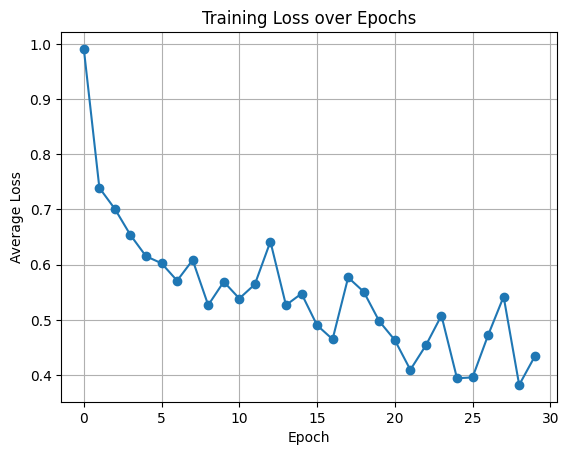

In [31]:
plt.plot(loss_history, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.show()